In [3]:
!pip install -r /kaggle/input/rreeeee/requirements.txt --ignore-installed llvmlite

  Using cached llvmlite-0.39.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.6 MB)
  Using cached anyio-3.6.2-py3-none-any.whl (80 kB)
  Using cached appnope-0.1.3-py2.py3-none-any.whl (4.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 351.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 671.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.9/160.9 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.2 MB/s eta 0:00:00:00:0100:01
  Using cached certifi-2022.9.24-py3-none-any.whl (161 kB)
  Using cached cffi-1.15.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (427 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)
  Using cached debugpy-1.6.3-cp37-cp37m-manylinux_2_5_x86_64.man

## Импорты

In [5]:
import warnings
warnings.simplefilter('ignore')

import dill
import numpy as np
import pandas as pd
import requests
import shap

from lightfm import LightFM
from lightfm.data import Dataset
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

#from tools import generate_lightfm_recs_mapper, avg_user_metric

In [6]:
from typing import Callable, Dict, Set, List, Optional

import numpy as np
from lightfm import LightFM
from scipy.sparse import csr_matrix


def generate_lightfm_recs_mapper(
    model: LightFM, 
    N: int, 
    item_iids: List[int],  # iid - internal lfm id
    user_id_to_iid: Dict[int, int], 
    item_iid_to_id: Dict[int, int], 
    known_item_ids: Dict[int, Set[int]],
    user_features:  Optional[csr_matrix] = None, 
    item_features: Optional[csr_matrix] = None, 
    num_threads: int = 1,
) -> Callable:
    """Возвращает функцию для генерации рекомендаций в формате item_ids, scores"""
    def _recs_mapper(user):
        # Предикт для одного юзера
        user_id = user_id_to_iid[user]
        # Получаем список скоров. index - соответствует внутренним 
        # индексам lightfm для айтемов т.е. ключам из item_iid_to_id
        scores_vector = model.predict(user_id, item_iids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)
        # Оставляем запас для исключения уже просмотренного из рекомендаций
        additional_N = len(known_item_ids[user_id]) if user_id in known_item_ids else 0
        total_N = N + additional_N
        # Получаем список индексов топ-N айтемов
        top_iids = np.argpartition(scores_vector, -np.arange(total_N))[-total_N:][::-1]
        # Исключаем уже просмотренное из рекомендаций
        if additional_N > 0:
            filter_items = known_item_ids[user_id]
            top_iids = [item_index for item_index in top_iids if item_iid_to_id[item_index] not in filter_items]
        # Переводим индексы lightfm айтемов в их реальные id
        final_recs = [item_iid_to_id[item_index] for item_index in top_iids]
        # Сохраняем скоры
        final_scores = scores_vector[top_iids]
        return final_recs, final_scores
    return _recs_mapper


def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score



## Подготовка данных

In [17]:
interactions = pd.read_csv('/kaggle/input/kion-data/interactions.csv')
items = pd.read_csv('/kaggle/input/kion-data/items.csv')
users = pd.read_csv('/kaggle/input/kion-data/users.csv')

### `interactions`: взаимодействия пользователь - айтем 
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [19]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [20]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [21]:
interactions.describe(datetime_is_numeric=True)

,user_id,item_id,datetime,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


### `users`: данные о пользователях

- `age` бин по возрасту 
- `income` бин по доходу 
- `sex` пол 
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [22]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [23]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [24]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [25]:
# Наиболее популярны income - income_40_60
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова 
- `description` - описание

In [26]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [27]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id', 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [28]:
items.describe(include='all')

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


## Трейн-вал-тест сплит

In [29]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации

In [30]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам 
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)  

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [31]:
# Для базовых моделей первого уровня (в нашем случае только lightfm) 
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## Обучаем модель первого уровня

In [32]:
# В рамках семинара мы не будем обучать большое количество моделей первого уровня и
# ограничимся только LightFM
lightfm_dataset = Dataset()
lightfm_user_ids = base_models_data['user_id'].unique()
lightfm_item_ids = base_models_data['item_id'].unique()
lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)

In [33]:
# В качестве таргета можно придумать что-то сложное на основе имеющихся
# процента досмотра или абсолютного значения просмотра.
# Как один из вариантов - возьмем процент досмотра - watched_pct (Columns.Weight).

# Тогда матрицу интеракций и весов можно получить следующим образом:
interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
    zip(*base_models_data[['user_id', 'item_id', Columns.Weight]].values.T)
)
weights_matrix = weights_matrix.tocsr()

In [34]:
# Обучаем модель
# Не используем доступные фичи юзеров и айтемов, оставим это на этап реранжирования

lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    # Статья про warp-loss:
    #  https://static.googleusercontent.com/media/research.google.com/ru//pubs/archive/37180.pdf
    # Описание варп-лосса в доке LightFM:
    #  https://making.lyst.com/lightfm/docs/examples/warp_loss.html
    loss='warp', 
    max_sampled=5, 
    random_state=42,
)

num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
# save model  
#!mkdir models
with open(f'models/lfm_model.dill', 'wb') as f:
    dill.dump(lfm_model, f)

## Генерим кандидатов, которыми дополним датасет ранкера

In [38]:
# Маппинги обычных айдишников во внутренние индексы lightfm для юзеров и айтемов
lightfm_mapping = lightfm_dataset.mapping()
lightfm_mapping = {
    'user_id_to_iid': lightfm_mapping[0],  # iid - internal lfm id
    'item_id_to_iid': lightfm_mapping[2],
}
# Маппинги внутренние индексов lightfm в обычные айдишники для юзеров и айтемов
lightfm_mapping['user_iid_to_id'] = {v: k for k, v in lightfm_mapping['user_id_to_iid'].items()}
lightfm_mapping['item_iid_to_id'] = {v: k for k, v in lightfm_mapping['item_id_to_iid'].items()}

In [39]:
# Топ 100 кандидатов 
# Как понять сколько их нужно?
top_N = 100

# Внутренние индексы юзеров и айтемов lightfm (индексы матрицы user-item)
user_lfm_index = np.array(list(lightfm_mapping['user_id_to_iid'].values()))
item_lfm_index = np.array(list(lightfm_mapping['item_id_to_iid'].values()))

# Делаем предикт, ограничиваем его сверху top_N 
# и сразу переводим в настоящие айдишники
mapper = generate_lightfm_recs_mapper(
    model=lfm_model, 
    N=top_N,
    item_iids=item_lfm_index, 
    user_id_to_iid=lightfm_mapping['user_id_to_iid'],
    item_iid_to_id=lightfm_mapping['item_iid_to_id'],
    known_item_ids=dict(),  # тут можно добавить уже просмотренный контент для его исключения
    num_threads=4,
)

In [41]:
!mkdir data

In [ ]:
# Генерируем предсказания и получаем скоры и ранги lightfm

candidates = pd.DataFrame({'user_id': lightfm_user_ids})
candidates['item_id'], candidates['lfm_score'] = zip(*candidates['user_id'].map(mapper))
candidates = candidates.explode(['item_id', 'lfm_score'], ignore_index=True)
candidates['lfm_rank'] = candidates.groupby('user_id').cumcount() + 1 

# Делаем чекпоинт - сохраняем кандидатов
candidates.to_csv('data/candidates.csv', index=False)

candidates.head(3)

In [ ]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')
models_metrics['lfm']

## Формируем датасет для ранкера

### Генерим фичи для ранкера

In [ ]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)

In [ ]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

In [ ]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно, 
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

### Джойним кандидатов и юзер/айтем фичи

In [ ]:
# Загружаем список айтемов-кандидатов. 
# Модель lightfm нам больше не понадобится

candidates = pd.read_csv('data/candidates.csv')
candidates.head(3)

In [ ]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='outer',  # right ? 
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['lfm_score'].min() - 0.01
    max_rank: int = df['lfm_rank'].max() + 1  # 101
    
    default_values = {
        'lfm_score': min_score, 'lfm_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций, 
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

In [ ]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет, 
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

In [ ]:
# Датасеты готовы, остались только таргеты, 
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.

# Не пользуемся методом eval если точно не знаем, что за строка.
# Он не безопасен и долго работает.
# Можно заменить на locals()[name]
for name in ['train', 'val', 'test']:
    path: str = f'data/ranker_{name}.csv'
    # eval(f'ranker_{name}').to_csv(path, index=False)
    locals()[f'ranker_{name}'].to_csv(path, index=False)

## Обучаем ранкер
### Pointwise

In [32]:
# Загружаем данные
for name in ['train', 'val', 'test']:
    path: str = f'data/ranker_{name}.csv'
    locals()[f'ranker_{name}'] = pd.read_csv(path)

In [33]:
# таргет бинарный, так что - 
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,14,2021-07-01,0.0,0.0,2.818984,93.0,-1,-1,-1,...,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0
1,3,47,2021-08-16,2179.0,27.0,-9.412899,101.0,-1,-1,-1,...,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144,0
2,3,101,2021-07-01,0.0,0.0,3.396656,49.0,-1,-1,-1,...,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0


In [34]:
# В train и val можно удалить 'плохих' пользователей, 
# Например тех у кого слишком много или мало просмотров или 
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df, 
        groups_df, 
        how='left', 
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 100]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
# ranker_test = filter_group(ranker_test)

In [35]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'lfm_score',
       'lfm_rank', 'age', 'income', 'sex', 'kids_flg', 'user_hist',
       'user_avg_pop', 'user_last_pop', 'content_type', 'release_year',
       'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
       'target'],
      dtype='object')

In [36]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'lfm_score', 'lfm_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [37]:
params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[4]	valid_0's binary_logloss: 0.0560035

[8]	valid_0's binary_logloss: 0.0529779

[12]	valid_0's binary_logloss: 0.0522068

[16]	valid_0's binary_logloss: 0.0518738

[20]	valid_0's binary_logloss: 0.0516466

[24]	valid_0's binary_logloss: 0.0515883

[28]	valid_0's binary_logloss: 0.0514994

[32]	valid_0's binary_logloss: 0.051413

[36]	valid_0's binary_logloss: 0.051357

[40]	valid_0's binary_logloss: 0.0513045

[44]	valid_0's binary_logloss: 0.0512536

[48]	valid_0's binary_logloss: 0.0512096

[52]	valid_0's binary_logloss: 0.0511848

[56]	valid_0's binary_logloss: 0.0511384

[60]	valid_0's binary_logloss: 0.051117

[64]	valid_0's binary_logloss: 0.0511011

[68]	valid_0's binary_logloss: 0.0510497

[72]	valid_0's binary_logloss: 0.0510125

[76]	valid_0's binary_logloss: 0.0509758

[80]	valid_0's binary_logloss: 0.0509566

[84]	valid_0's binary_logloss: 0.0509434

[88]	valid_0's binary_logloss: 0.0508985

[92]	valid_0's binary_logloss: 0.0508608

[96]	valid_0's binary_logloss: 0.050828

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.25, max_depth=4,
               min_child_samples=100, n_estimators=10000, num_leaves=10,
               objective='binary', random_state=42, reg_lambda=1)

In [38]:
# save model  
with open(f'models/pointwise_model.dill', 'wb') as f:
    dill.dump(pointwise_model, f)

In [39]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.050036496293642645

In [40]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

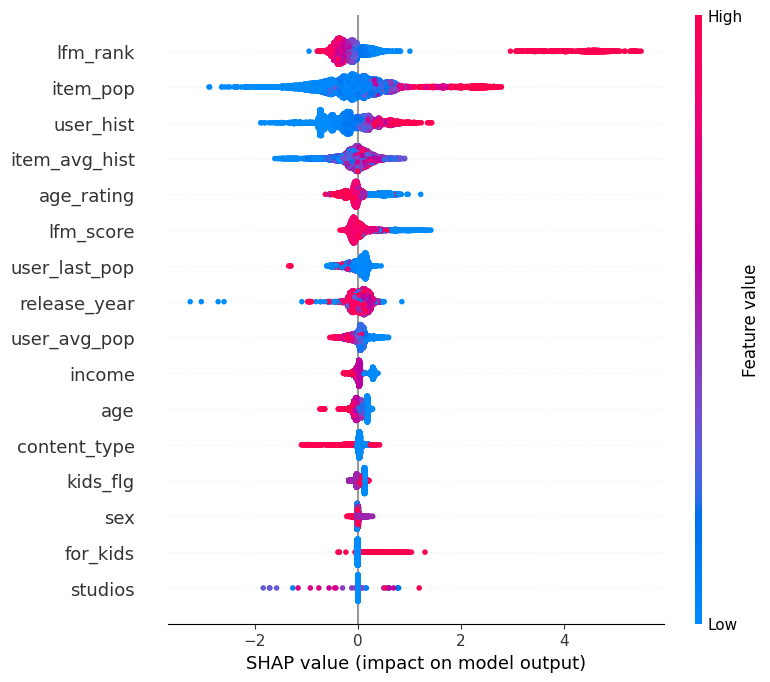

In [41]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

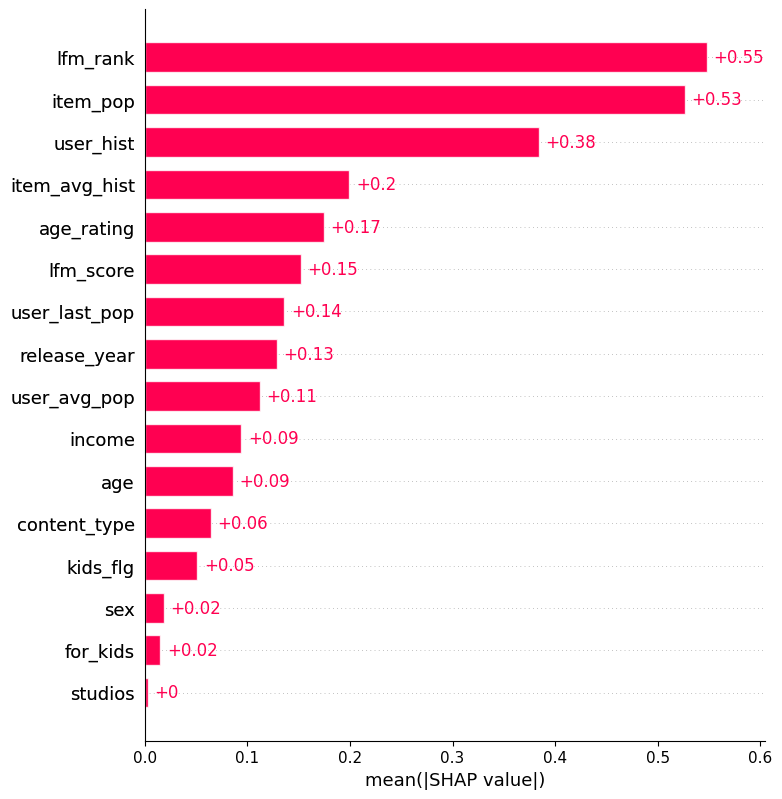

In [42]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [43]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.2706265 , 0.21741635, 0.1811573 , ..., 0.03610982, 0.04619891,
       0.36363694])

In [44]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['lfm_rank'] < 101).to_numpy()
    # Добавляем общий скор двух-этапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двух-этапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
0,1,3669,2021-08-16,1593.0,26.0,-8.841009,101.0,1,2,0,...,-1,18.0,-1,2846.0,22.675978,0,0.270626,1,-0.000997,101
1,1,10440,2021-08-13,19579.0,80.0,-8.841009,101.0,1,2,0,...,-1,18.0,-1,141889.0,8.068716,1,0.217416,2,-0.000997,101
2,12,846,2021-08-21,5929.0,18.0,-8.841009,101.0,-1,-1,-1,...,0,16.0,-1,528.0,22.799242,0,0.181157,1,-0.000997,101


In [45]:
# Считаем рок аук от sklearn (не усредненный по юзерам)
roc_auc_score(y_true, y_pred)  # Получилась ерунда

0.9484334408674613

In [46]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ), 
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)
# Ранкер вроде ранжирует, но вот весь пайплайн в целом - не очень

(0.824900238147325, 0.40736144713705513)

In [47]:
# Получим значения метрик, а так же
# вспомним, какие метрики были у LightFM и сравним их между собой. Что не так?
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'pointwise', 'pointwise_hybrid']]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.021061,0.296531,0.018268
recall@10,0.071047,0.890900,0.077276
ndcg@10,0.023391,0.408446,0.018832
map@10,0.028438,0.850568,0.032878
novelty@10,4.399781,6.011618,3.126150


#### Исправляем баг в users_filter

In [48]:
# Исправляем баг, с outher join в users_filter
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 100]

ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [49]:
# Обучаем модель заново, на очищенных данных
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)
print(pointwise_model.best_score_['valid_0'])

[4]	valid_0's binary_logloss: 0.0325145

[8]	valid_0's binary_logloss: 0.0321153

[12]	valid_0's binary_logloss: 0.0318997

[16]	valid_0's binary_logloss: 0.0317392

[20]	valid_0's binary_logloss: 0.0315928

[24]	valid_0's binary_logloss: 0.0315117

[28]	valid_0's binary_logloss: 0.031438

[32]	valid_0's binary_logloss: 0.0314013

[36]	valid_0's binary_logloss: 0.031369

[40]	valid_0's binary_logloss: 0.0313162

[44]	valid_0's binary_logloss: 0.0312878

[48]	valid_0's binary_logloss: 0.0312635

[52]	valid_0's binary_logloss: 0.0312285

[56]	valid_0's binary_logloss: 0.0311977

[60]	valid_0's binary_logloss: 0.0311774

[64]	valid_0's binary_logloss: 0.0311597

[68]	valid_0's binary_logloss: 0.0311432

[72]	valid_0's binary_logloss: 0.0311282

[76]	valid_0's binary_logloss: 0.031097

[80]	valid_0's binary_logloss: 0.0310821

[84]	valid_0's binary_logloss: 0.0310732

[88]	valid_0's binary_logloss: 0.0310485

[92]	valid_0's binary_logloss: 0.0310333

[96]	valid_0's binary_logloss: 0.031014

In [50]:
# save model  
with open(f'models/pointwise_model.dill', 'wb') as f:
    dill.dump(pointwise_model, f)

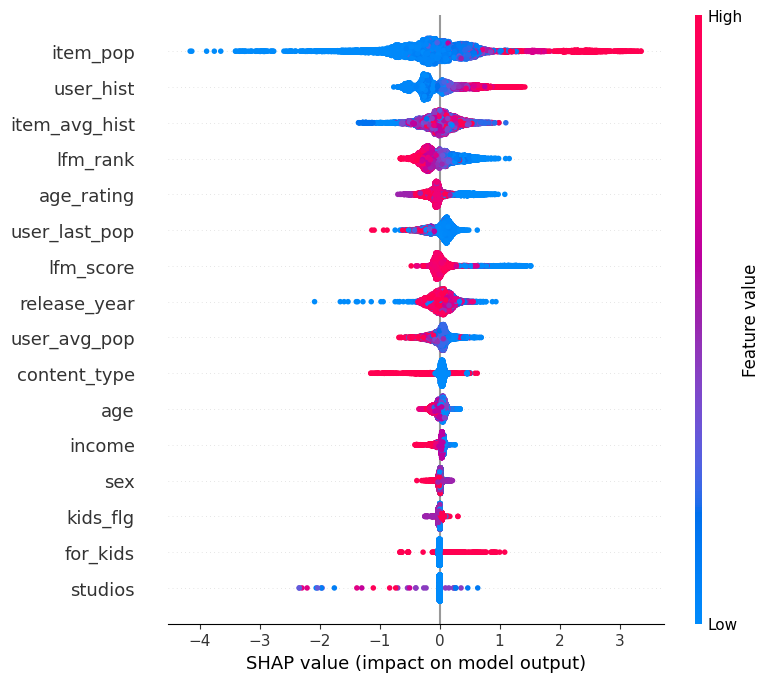

In [51]:
# Проверяем как изменилить shap-values

# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [52]:
# Получаем предикты и смотрим на метрики
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
ranker_test = add_score_and_rank(ranker_test, y_pred, 'fixed_pointwise')

models_metrics['fixed_pointwise'] = calc_metrics_(ranker_test, 'fixed_pointwise_rank')
models_metrics['fixed_pointwise_hybrid'] = calc_metrics_(ranker_test, 'fixed_pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'fixed_pointwise_hybrid', 'pointwise_hybrid']]

,lfm,fixed_pointwise_hybrid,pointwise_hybrid
Precision@10,0.021061,0.025167,0.018268
recall@10,0.071047,0.083374,0.077276
ndcg@10,0.023391,0.031584,0.018832
map@10,0.028438,0.042269,0.032878
novelty@10,4.399781,3.475882,3.126150


### Pairwise/Listwise - LightGBM

In [53]:
# Для обучения ранжированию нужно правильно сформировать группы. 
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества 
# ранжируемых айтемов на каждого юзера (группу).

# Официальная [дока|https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker]:
# sum(group) = n_samples. 
# For example, if you have a 100-document dataset with 
# group = [10, 20, 40, 10, 10, 10], that means that you have 6 groups, 
# where the first 10 records are in the first group

# Важно! Если вы решите использовать CatBoostRanker или XGBoostRanker - там группы строятся по-другому.

def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [54]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,14,2021-07-01,0.0,0.0,2.818984,93.0,-1,-1,-1,...,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0,0
2,3,101,2021-07-01,0.0,0.0,3.396656,49.0,-1,-1,-1,...,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0,0
3,3,142,2021-08-13,5892.0,100.0,4.585184,7.0,-1,-1,-1,...,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1,2


In [55]:
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg 
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[4]	valid_0's ndcg@3: 0.625922	valid_0's ndcg@5: 0.647422	valid_0's ndcg@10: 0.672237

[8]	valid_0's ndcg@3: 0.628735	valid_0's ndcg@5: 0.652498	valid_0's ndcg@10: 0.674965

[12]	valid_0's ndcg@3: 0.629969	valid_0's ndcg@5: 0.65334	valid_0's ndcg@10: 0.676357

[16]	valid_0's ndcg@3: 0.631241	valid_0's ndcg@5: 0.654318	valid_0's ndcg@10: 0.678352

[20]	valid_0's ndcg@3: 0.631666	valid_0's ndcg@5: 0.654905	valid_0's ndcg@10: 0.679075

[24]	valid_0's ndcg@3: 0.63204	valid_0's ndcg@5: 0.655735	valid_0's ndcg@10: 0.679583

[28]	valid_0's ndcg@3: 0.632654	valid_0's ndcg@5: 0.656254	valid_0's ndcg@10: 0.680412

[32]	valid_0's ndcg@3: 0.635677	valid_0's ndcg@5: 0.659461	valid_0's ndcg@10: 0.683094

[36]	valid_0's ndcg@3: 0.636361	valid_0's ndcg@5: 0.660348	valid_0's ndcg@10: 0.683573

[40]	valid_0's ndcg@3: 0.636981	valid_0's ndcg@5: 0.660601	valid_0's ndcg@10: 0.683624

[44]	valid_0's ndcg@3: 0.637043	valid_0's ndcg@5: 0.660703	valid_0's ndcg@10: 0.684035

[48]	valid_0's ndcg@3: 0.637578	vali

LGBMRanker(colsample_bytree=0.9, learning_rate=0.25, max_depth=4,
           min_child_samples=100, n_estimators=10000, num_leaves=10,
           objective='lambdarank', random_state=42, reg_lambda=1)

In [56]:
# save model  
with open(f'models/listwise_model.dill', 'wb') as f:
    dill.dump(listwise_model, f)

In [57]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.6403293965195808),
             ('ndcg@5', 0.664047830851),
             ('ndcg@10', 0.6869986113951889)])

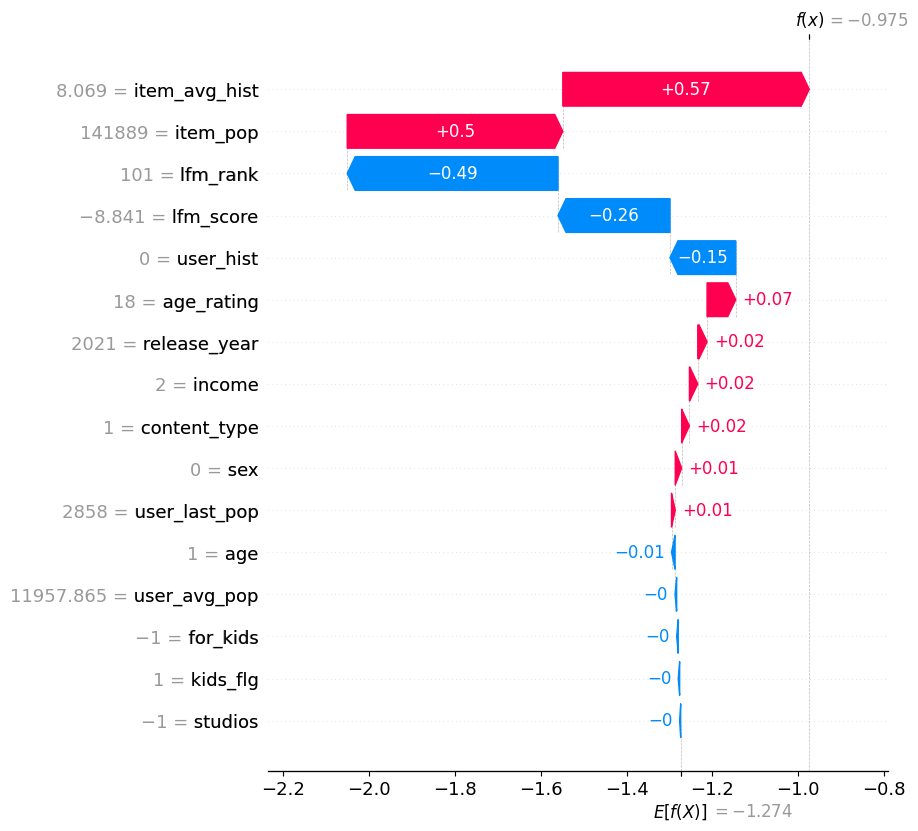

In [58]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

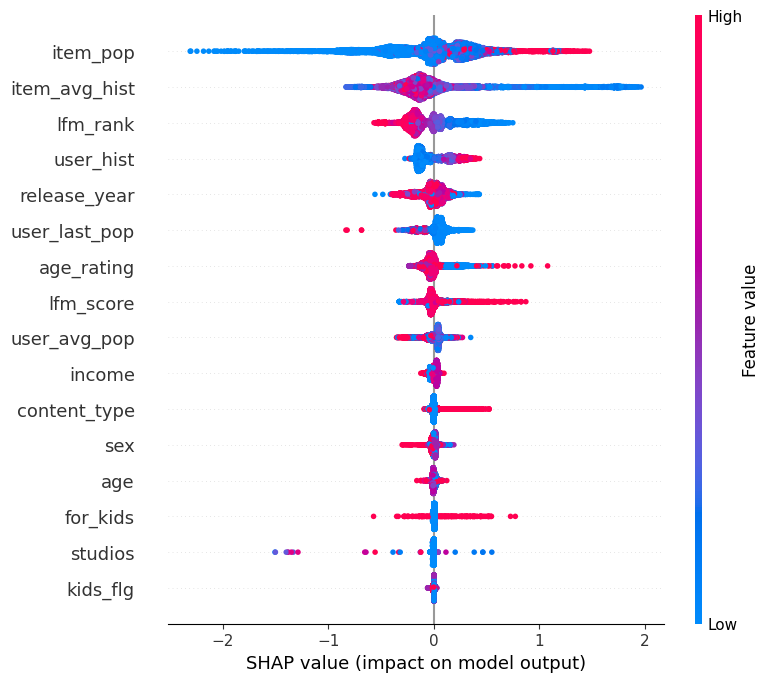

In [59]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

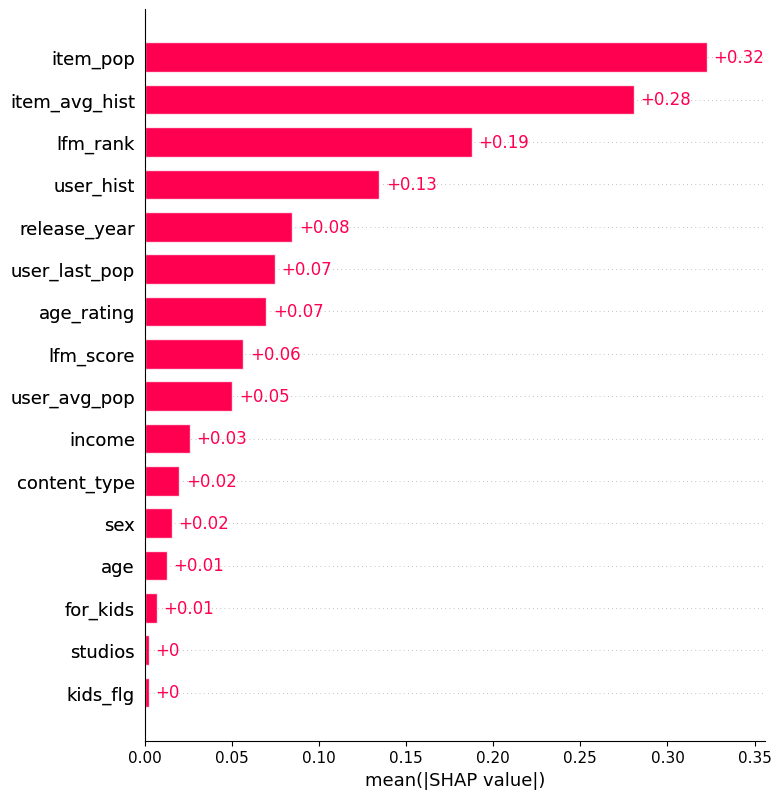

In [60]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [61]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,pointwise_hybrid_rank,fixed_pointwise_score,fixed_pointwise_rank,fixed_pointwise_hybrid_score,fixed_pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
1,1,10440,2021-08-13,19579.0,80.0,-8.841009,101.0,1,2,0,...,101,0.020839,1,-0.000999,101,2,-0.974714,1,-6.174892,101
0,1,3669,2021-08-16,1593.0,26.0,-8.841009,101.0,1,2,0,...,101,0.009782,2,-0.000999,101,1,-1.555667,2,-6.174892,101
2,12,846,2021-08-21,5929.0,18.0,-8.841009,101.0,-1,-1,-1,...,101,0.010007,1,-0.000999,101,1,-1.434597,1,-6.174892,101


In [62]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

,listwise,listwise_hybrid
Precision@10,0.188808,0.027670
recall@10,0.647638,0.092687
ndcg@10,0.264405,0.034024
map@10,0.593994,0.045439
novelty@10,5.328685,3.420913


In [64]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.5520428945252395, 0.4074480959635377)

### Pairwise/Listwise - XGBoost

In [ ]:
def get_group_xgb(df: pd.DataFrame) -> np.ndarray:
    return df[['user_id', 'item_id']].groupby('user_id').size().to_frame('size')['size'].to_numpy()

In [ ]:
import xgboost as xgb

early_stopping_rounds = 32

fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group_xgb(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group_xgb(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}

model = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )

model.fit(**fit_params)


In [ ]:
with open(f'models/listwise_model_xgb.dill', 'wb') as f:
    dill.dump(model, f)

In [ ]:
model.best_score_['valid_0']

In [ ]:
y_pred: np.ndarray = model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

## Итоговые метрики

In [65]:
pd.DataFrame(models_metrics)[['lfm', 'fixed_pointwise_hybrid', 'listwise_hybrid']]

,lfm,fixed_pointwise_hybrid,listwise_hybrid
Precision@10,0.021061,0.025167,0.027670
recall@10,0.071047,0.083374,0.092687
ndcg@10,0.023391,0.031584,0.034024
map@10,0.028438,0.042269,0.045439
novelty@10,4.399781,3.475882,3.420913
